## Imports

In [1]:
from pysis import isis

from plio.io import io_controlnetwork
from knoten.csm import create_csm
from scipy import sparse
import ale
import csmapi
import numpy as np

import matplotlib.pyplot as plt

from knoten.bundle import *

## Load Network and Generate Sensors
- Generate a set of USGSCSM sensor models from a list of ISIS cube files
- Generate a plio dataframe from an ISIS control network
- Compute a priori ground points for all of the free points in a control network.

In [2]:
cubes = 'data/cubes.lis'
sensors = generate_sensors(cubes)

network = 'data/hand_dense.net'
cnet = io_controlnetwork.from_isis(network)
cnet = compute_apriori_ground_points(cnet, sensors) # autoseed did not generate ground points, calculate and repopulate the data frame

## Determine Which Sensor Parameters to Solve For
Get a set of the CSM parameters for each CSM sensor in the sensors set

In [3]:
all_parameters = {sn: get_sensor_parameters(sensor) for sn, sensor in sensors.items()}
for sn, parameters in all_parameters.items():
    print(f"Image: {sn}")
    for param in parameters:
        print(f"  {param.name} | {param.index} | {param.value}")

Image: MRO/CTX/1085197697:073
  IT Pos. Bias    | 0 | 0.0
  CT Pos. Bias    | 1 | 0.0
  Rad Pos. Bias   | 2 | 0.0
  IT Vel. Bias    | 3 | 0.0
  CT Vel. Bias    | 4 | 0.0
  Rad Vel. Bias   | 5 | 0.0
  Omega Bias      | 6 | 0.0
  Phi Bias        | 7 | 0.0
  Kappa Bias      | 8 | 0.0
  Omega Rate      | 9 | 0.0
  Phi Rate        | 10 | 0.0
  Kappa Rate      | 11 | 0.0
  Omega Accl      | 12 | 0.0
  Phi Accl        | 13 | 0.0
  Kappa Accl      | 14 | 0.0
  Focal Bias      | 15 | 0.0
Image: MRO/CTX/1096561308:045
  IT Pos. Bias    | 0 | 0.0
  CT Pos. Bias    | 1 | 0.0
  Rad Pos. Bias   | 2 | 0.0
  IT Vel. Bias    | 3 | 0.0
  CT Vel. Bias    | 4 | 0.0
  Rad Vel. Bias   | 5 | 0.0
  Omega Bias      | 6 | 0.0
  Phi Bias        | 7 | 0.0
  Kappa Bias      | 8 | 0.0
  Omega Rate      | 9 | 0.0
  Phi Rate        | 10 | 0.0
  Kappa Rate      | 11 | 0.0
  Omega Accl      | 12 | 0.0
  Phi Accl        | 13 | 0.0
  Kappa Accl      | 14 | 0.0
  Focal Bias      | 15 | 0.0
Image: MRO/CTX/1136952576:186
  

In [4]:
# Solve for angles and angular rates
solve_parameters = {sn: params[6:12] for sn, params in all_parameters.items()}

## Compute the Column Indices for Parameters
Obtain dictionary that maps serial numbers and point IDs to the column range their parameters are in the Jacobian matrix.

In [5]:
column_dict = compute_coefficient_columns(cnet, sensors, solve_parameters)
# num_parameters = max(col_range[1] for col_range in column_dict.values())

## Compute the Weight Matrix
- According to the weighted Normal equation (J.TWJ), W needs to be a square matrix the size of (# of measures)x2. So it is the weight of the observations. In ISIS, the weight of the observations are an inverted function of the size of the pixels on the focal plane (resolution). However, in csm we do not have access to that information. 
- For the time being, since we are working exclusively with CTX images we are going to set the weight matrix equal to the identity matrix -> all observations have the same weight.

In [6]:
num_observations = 2 * len(cnet)
W_observations = np.eye(num_observations) # this is a place holder until Jesse adds his calculations
W_params = compute_parameter_weights(cnet, sensors, solve_parameters, column_dict)

## Calculate Initial Sigma0
Compute the resulting standard deviation of the residuals for the current state of the bundle network.

In [7]:
V = compute_residuals(cnet, sensors)
dX = np.zeros(W_params.shape[0])
sigma0 = compute_sigma0(V, dX, W_params, W_observations)

print((sigma0))

2.5961263976217976


## Populate Jacobian
Compute the Jacobian matrix with controlnet, set of sensors, solve parameters, and coefficient columns

In [8]:
J = compute_jacobian(cnet, sensors, solve_parameters, column_dict)

## Bundle Iteration

In [9]:
def bundle_iteration(J, V, W_parameters, W_observations):
    """
    Parameters
    ----------
    J  :  ndarray
          The Jacobian matrix
    V  :  np.array
          An array of residuals of the difference between registered measure 
          and back projected ground points in image space.
    W_parameters  :  ndarray 
                     The parameter weight matrix (i.e.: sensor parameters and point weights)
    W_observations  :  ndarray
                     The observation weight matrix (i.e.: measure weights)
    
    Returns
    -------
    N  :  np.ndarray
          Normal equation matrix 
    
    dX  :  np.ndarray
           An array of updated parameter values
    """
    
    N = J.T.dot(W_observations).dot(J) + W_parameters
    C = J.T.dot(W_observations).dot(V)
    dX = np.linalg.inv(N).dot(C)
    return N, dX

In [10]:
N, dX = bundle_iteration(J, V, W_params, W_observations)
print(dX.shape)

(129,)


## Calculate Updated Sigma0

In [11]:
dof = W_observations.shape[0] - W_params.shape[0]
VTPV = V.dot(W_observations).dot(V) - dX.dot(J.T).dot(W_observations).dot(V)
if (dof > 0):
    updated_sigma0 = np.sqrt(VTPV/dof)
else:
    updated_sigma0 = np.sqrt(VTPV)
print(updated_sigma0)

1.3577841505153914


## Redundancy Number

Minimum redundancy: 0.7502088509294791
Maximum redundancy: 0.9653389403009147


{'whiskers': [<matplotlib.lines.Line2D at 0x1ad6cea60>,
 'caps': [<matplotlib.lines.Line2D at 0x1ad6cefa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ad6ce7c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ad6ec520>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ad6ec7c0>],
 'means': []}

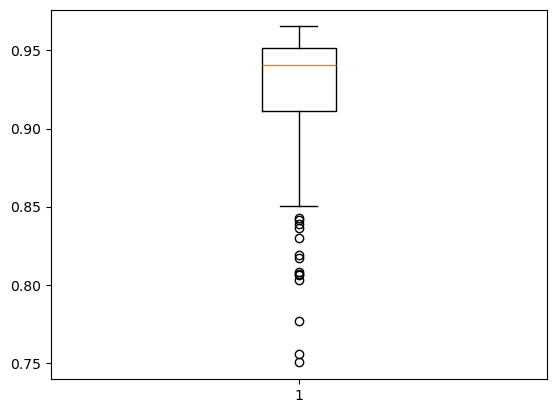

In [12]:
# redundancy for every measure
# vector will hold same order as the measures in the cnet df
# def compute_measure_redundancy
def compute_redundancy(N, W_observations, J):
    Qxx = np.linalg.inv(N)
    Qvv = np.linalg.inv(W_observations) - J.dot(Qxx).dot(J.T)
    r = np.diagonal(Qvv.dot(W_observations))
    
    return r

r = compute_redundancy(N, W_observations, J)
print(f'Minimum redundancy: {min(r)}')
print(f'Maximum redundancy: {max(r)}')
plt.boxplot(r)

## Whole bundle process in a loop

In [13]:
sensors = generate_sensors(cubes) # generate sensors
cnet = io_controlnetwork.from_isis(network) # load in network
cnet = compute_apriori_ground_points(cnet, sensors) # calculate ground points

### INPUTS ###
all_parameters = {sn: get_sensor_parameters(sensor) for sn, sensor in sensors.items()} #all parameters
parameters = {sn: parameter[:3] for sn, parameter in all_parameters.items()} #just solving for camera angles and angle velocity
##############

column_dict = compute_coefficient_columns(cnet, sensors, parameters)
num_parameters = max(col_range[1] for col_range in column_dict.values())
num_observations = 2 * len(cnet)
W_observations = np.eye(num_observations)
W_params = compute_parameter_weights(cnet, sensors, parameters, column_dict)

iteration = 0
V = compute_residuals(cnet, sensors)
dX = np.zeros(W_params.shape[0]) #initialize for sigma calculatioN
sigma0 = compute_sigma0(V, dX, W_params, W_observations)
print(f'iteration {iteration}: sigma0 = {sigma0}\n')

max_iterations = 50
tol = 1e-10
total_correction = np.zeros(num_parameters)
for i in range(max_iterations): 
    iteration += 1
    old_sigma0 = sigma0

    J = compute_jacobian(cnet, sensors, parameters, column_dict)    
    N = J.T.dot(W_observations).dot(J) + W_params # calculate the normal equation
    C = J.T.dot(W_observations).dot(V) - W_params.dot(total_correction)
    dX = np.linalg.inv(N).dot(C) #calculate change in camera parameters and ground points
    total_correction += dX
    print(f'corrections: mean = {dX.mean()} min = {dX.min()} max = {dX.max()}')
    
    update_parameters(sensors, parameters, cnet, dX, column_dict)
    V = compute_residuals(cnet, sensors)
    sigma0 = compute_sigma0(V, dX, W_params, W_observations)
    print(f'iteration {iteration}: sigma0 = {sigma0}\n')
    if (abs(sigma0 - old_sigma0) < tol):
        print(f'change in sigma0 of {abs(sigma0 - old_sigma0)} converged!')
        onet = io_controlnetwork.to_isis(cnet, 'data/py-adjusted.net', targetname="Mars")
        break
    

iteration 0: sigma0 = 4.0255575933213645

corrections: mean = 0.0607625027080373 min = -15.894645144585613 max = 43.173076576185686
iteration 1: sigma0 = 1.3372395601830835

corrections: mean = -1.9487862295781398e-05 min = -0.002348815201592963 max = 0.0011802360614414334
iteration 2: sigma0 = 1.116733991093145

corrections: mean = -6.40338937723717e-10 min = -5.349525439150892e-08 max = 4.348174825756319e-08
iteration 3: sigma0 = 1.116733988965997

corrections: mean = -8.137793063550186e-11 min = -6.4754516024339534e-09 max = 9.929915597684175e-09
iteration 4: sigma0 = 1.1167339889935555

change in sigma0 of 2.7558400006455486e-11 converged!


/Users/astamile/opt/anaconda3/envs/knoten/lib/python3.9/site-packages/plio/io/io_controlnetwork.py:356: UserWarning: The pointLog field is currently unsupported. Any pointLog data will not be saved.
  warnings.warn('The pointLog field is currently unsupported. Any pointLog data will not be saved.')
